In [53]:
import pandas as pd
import pymysql as ps 
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 

In [9]:
# List all the csv files and there corresponding tabel to be appear in SQL database 
csv_files = [
    ('customers.csv','Customer'),
    ('orders.csv','orders'),
    ('sellers.csv','sellers'),
    ('products.csv','products'),
    ('geolocation.csv','geolocation'),
    ('payments.csv','payments'),
    ('order_items.csv','order_items')
]


# make connection to mysql database 

conn = ps.connect(
    host = 'localhost',
    user = 'root',
    password='Yogesh@123',
    database='ecommerce'
)

cursor = conn.cursor()

# give folder path 

folder_path = 'D:\Data Analysis Project'


def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

<>:26: SyntaxWarning: invalid escape sequence '\D'
<>:26: SyntaxWarning: invalid escape sequence '\D'
C:\Users\yogesh\AppData\Local\Temp\ipykernel_17488\1006801759.py:26: SyntaxWarning: invalid escape sequence '\D'
  folder_path = 'D:\Data Analysis Project'


Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [11]:
# Data analysis - A. Basic 5 questions

import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import seaborn 
import pymysql 

db = pymysql.connect(host = 'localhost',user='root',password='Yogesh@123',database='ecommerce')

cursor = db.cursor()


Q1. List all unique cities where our customers are located. 

In [14]:
query = 'SELECT DISTINCT(customer_city) FROM customer;'

cursor.execute(query)

data = cursor.fetchall()

In [15]:
data

((0.0,),)

Q2. Count the number of orders placed in 2017 

In [16]:
query = 'SELECT COUNT(order_id) FROM orders WHERE year(order_purchase_timestamp)=2017'

cursor.execute(query)
data = cursor.fetchall()

In [17]:
data

((45101,),)

Q3. Find the total sales per category

In [35]:
query = '''SELECT p.product_category,
ROUND(sum(pt.payment_value),2) AS total_sales_per_category 
FROM order_items oi
INNER JOIN products p USING(product_id)
INNER JOIN payments pt USING(order_id)
GROUP BY p.product_categorY;'''

cursor.execute(query)
data= cursor.fetchall()

In [37]:
pd.DataFrame(data, columns=['Category','Sales'])

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,Fashion Bags and Accessories,218158.28
4,bed table bath,1712553.67
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


Q4. Calcualte the percentage of orders that were placed in installments. 

In [38]:
query = '''SELECT (SUM(case WHEN payment_installments>=1 THEN 1 ELSE 0 END)/count(order_id))*100  FROM payments;'''

cursor.execute(query)
data = cursor.fetchall()

In [43]:
data[0][0]

Decimal('99.9981')

Q5. Count the number of customers from each state. 



In [47]:
query = '''SELECT customer_state,count(customer_id) as Total_customer FROM customer GROUP BY customer_state'''

cursor.execute(query)
data=cursor.fetchall()

In [50]:
df=pd.DataFrame(data,columns=['State','Number_of_Customer'])

Text(0.5, 1.0, 'Customer_per_State')

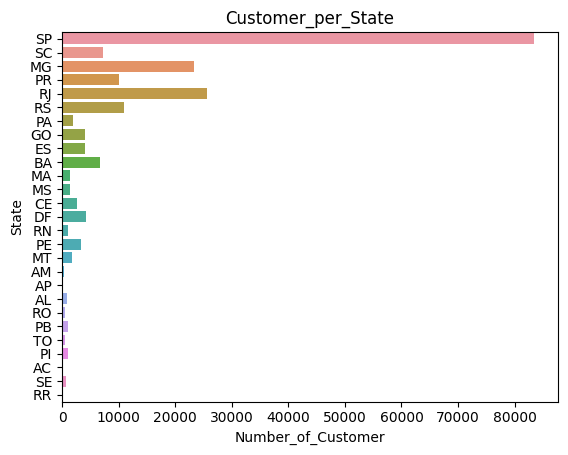

In [59]:
import warnings 
warnings.filterwarnings('ignore')
sns.barplot(x=df['Number_of_Customer'],y=df['State'])
plt.title('Customer_per_State')


Moving towards intermidiate questions:

Q1. Calculate the number of orders per month in 2018.

In [61]:
query = '''SELECT monthname(order_purchase_timestamp) AS Months,count(order_id) AS NUmber_of_orders
FROM orders 
WHERE year(order_purchase_timestamp)=2018
GROUP BY Months
ORDER BY Months ASC;'''

cursor.execute(query)
data = cursor.fetchall()

In [68]:
df = pd.DataFrame(data,columns=['Months','Order_Count'])
df.sort_values(by='Months',ascending=True)

,Months,Order_Count
0,April,6939
1,August,6512
2,February,6728
3,January,7269
4,July,6292
5,June,6167
6,March,7211
7,May,6873
8,October,4
9,September,16


In [84]:
o = ['January','February','March','April','May','June','July','Augast','Sept','Oct','Nov','Dec']


Text(0, 0.5, 'Order_count')

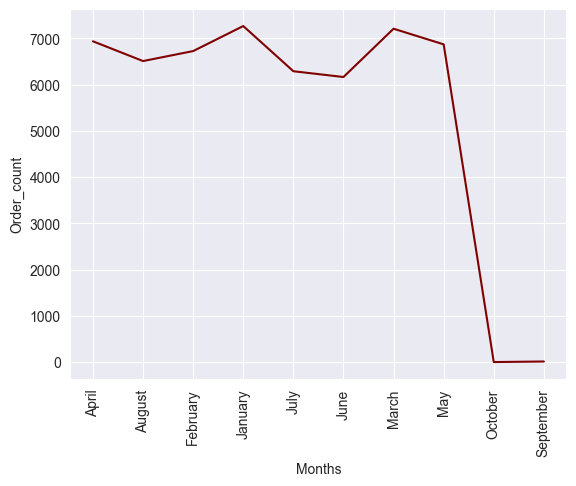

In [89]:
sns.set_style('darkgrid')
plt.plot(df['Months'],df['Order_Count'],color='maroon')
plt.xticks(rotation=90)
plt.xlabel('Months')
plt.ylabel('Order_count')

Q2. Find the average number of products per order, grouped by customer city.

In [90]:
query1 = '''SELECT customer_city,ROUND(AVG(count_per_order),2) AS Avg_order_perorder__per_city
FROM customer
INNER JOIN
(SELECT customer_id,oi.ordeR_id,count(product_id) as count_per_order 
FROM order_items oi
INNER JOIN orders o USING(order_id)
GROUP BY order_id,customer_id) t 
USING(customer_id)
GROUP BY customer_city;
'''
# OR 


query2 = '''with product_per_order AS
(SELECT o.customer_id,oi.order_id,count(oi.product_id) as Product_per_order
FROM order_items oi
INNER JOIN orders o USING(order_id)
GROUP BY customer_id,order_id)
SELECT customer_city,ROUND(AVG(Product_per_order),2) AS Avg_product_per_order_per_city
FROM customer AS C 
INNER JOIN product_per_order ppo USING(customer_id)
GROUP BY customer_city;
'''

cursor.execute(query1)
data=cursor.fetchall()

In [93]:
pd.DataFrame(data,columns=['City','Order_count'])

,City,Order_count
0,sao jose dos campos,1.14
1,indaial,1.12
2,treze tilias,1.27
3,sao paulo,1.16
4,rio de janeiro,1.15
...,...,...
4105,tibau do sul,1.00
4106,sao mamede,1.00
4107,sambaiba,1.00
4108,guairaca,2.00


Q3. Calculate the percentage of total revenue contributed by each product category.

In [96]:
query = '''SELECT p.product_category,
((ROUND(sum(pt.payment_value),2))/(SELECT SUM(payment_value) FROM payments))*100 AS total_sales_percentage_by_category 
FROM order_items oi
INNER JOIN products p USING(product_id)
INNER JOIN payments pt USING(order_id)
GROUP BY p.product_categorY;'''

cursor.execute(query)

data = cursor.fetchall()

In [99]:
pd.DataFrame(data,columns =['Category','Contributed%'])

,Category,Contributed%
0,perfumery,3.165361
1,Furniture Decoration,8.933649
2,telephony,3.041326
3,Fashion Bags and Accessories,1.362734
4,bed table bath,10.697529
...,...,...
69,cds music dvds,0.007492
70,La Cuisine,0.018199
71,Fashion Children's Clothing,0.004908
72,PC Gamer,0.013583


Q4. Identify the correlation between product price and the number of times a product has been purchased.

In [100]:
query = '''SELECT product_category, COUNT(product_id) AS order_count,AVG(Price) AS avg_price
FROM products P
INNER JOIN order_items oi USING(product_id) 
GROUP BY product_category;'''

cursor.execute(query)
data = cursor.fetchall()



In [102]:
df = pd.DataFrame(data,columns = ['Product_category','Order_count','Avg_price'])

In [103]:
df

,Product_category,Order_count,Avg_price
0,HEALTH BEAUTY,9670,130.163531
1,sport leisure,8641,114.344285
2,Cool Stuff,3796,167.357969
3,computer accessories,7827,116.513903
4,Watches present,5991,201.135984
...,...,...,...
69,flowers,33,33.637576
70,Kitchen portable and food coach,15,264.568666
71,House Comfort 2,30,25.342333
72,CITTE AND UPHACK FURNITURE,38,114.949473


<Axes: xlabel='Avg_price', ylabel='Order_count'>

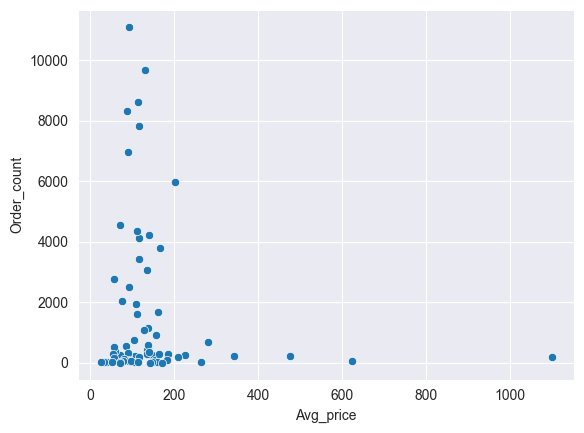

In [108]:
sns.scatterplot(x=df['Avg_price'],y=df['Order_count'])

In [109]:
df['Order_count'].corr(df['Avg_price']) #  No relation 

-0.10631552237549534

- When the corr value near to the neutral value or 0 it indicates that there isno relationship between the features. 

Q5. Calculate the total revenue generated by each seller, and rank them by revenue.

In [110]:
query = '''SELECT *,RANK() OVER(ORDER BY total_rev DESC) AS Ranky
FROM 
(SELECT seller_id,SUM(payment_value) as Total_rev 
FROM payments p 
INNER JOIN order_items oi USING(order_id) 
GROUP BY seller_id) AS W; '''

cursor.execute(query)
data = cursor.fetchall()

In [116]:
df = pd.DataFrame(data,columns=['seller_id','revenue','rank'])
df.head(10)

,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2
2,4a3ca9315b744ce9f8e9374361493884,301245.269765,3
3,1f50f920176fa81dab994f9023523100,290253.420128,4
4,53243585a1d6dc2643021fd1853d8905,284903.080498,5
5,da8622b14eb17ae2831f4ac5b9dab84a,272219.319315,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,264166.120939,7
7,955fee9216a65b617aa5c0531780ce60,236322.300502,8
8,fa1c13f2614d7b5c4749cbc52fecda94,206513.229870,9
9,7e93a43ef30c4f03f38b393420bc753a,185134.209706,10


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '7c67e1448b00f6e969d365cea6b010ab'),
  Text(1, 0, '1025f0e2d44d7041d6cf58b6550e0bfa'),
  Text(2, 0, '4a3ca9315b744ce9f8e9374361493884'),
  Text(3, 0, '1f50f920176fa81dab994f9023523100'),
  Text(4, 0, '53243585a1d6dc2643021fd1853d8905'),
  Text(5, 0, 'da8622b14eb17ae2831f4ac5b9dab84a'),
  Text(6, 0, '4869f7a5dfa277a7dca6462dcf3b52b2'),
  Text(7, 0, '955fee9216a65b617aa5c0531780ce60'),
  Text(8, 0, 'fa1c13f2614d7b5c4749cbc52fecda94'),
  Text(9, 0, '7e93a43ef30c4f03f38b393420bc753a')])

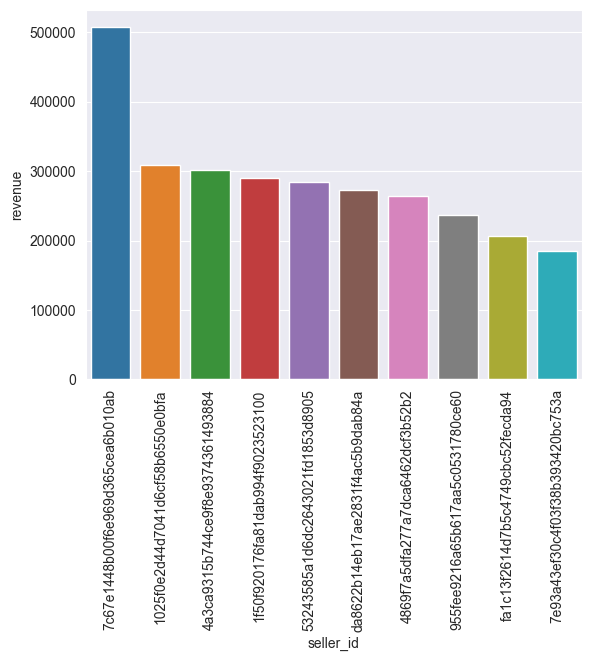

In [121]:
# Lets see the top 10 performer 
sns.barplot(x=df['seller_id'][0:10], y = df['revenue'][0:10])
plt.xticks(rotation=90)

Advance Querys 

Q1. Calculate the moving average of order values for each customer over their order history.

In [122]:
query = ''' SELECT customer_id,order_purchase_timestamp,payment, AVG(payment)
OVER(PARTITION BY customer_id ORDER BY order_purchase_timestamp ROWS BETWEEN 2 preceding AND CURRENT ROW) AS moving_avg
FROM
(
SELECT customer_id,order_id,o.order_purchase_timestamp,payment_value AS payment 
FROM orders o 
INNER JOIN payments USING(order_id)
GROUP BY customer_id,order_id) t;''' 

cursor.execute(query)
data=cursor.fetchall()

In [124]:
df =pd.DataFrame(data,columns=['customer_id','time_stamp','price','moving_avg'])
df

,customer_id,time_stamp,price,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
99435,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,0.64,0.640000
99436,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
99437,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
99438,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


Q2. Calculate the cumulative sales per month for each year.

In [125]:
query = '''SELECT years,months,payment,SUM(payment) 
OVER(ORDER BY years,months) AS cumulative_sum 
FROM 
(
SELECT year(o.order_purchase_timestamp) as years,
month(o.order_purchase_timestamp) AS months ,SUM(p.payment_value) AS payment
FROM orders o 
INNER JOIN payments p USING(order_id)
GROUP BY years,months 
ORDER BY years,months) E;
'''

cursor.execute(query)
data = cursor.fetchall()

In [127]:
df = pd.DataFrame(data,columns=['Years','Months','payment','Cumulative_sum'])
df

,Years,Months,payment,Cumulative_sum
0,2016,9,2.522400e+02,2.522400e+02
1,2016,10,5.909048e+04,5.934272e+04
2,2016,12,1.962000e+01,5.936234e+04
3,2017,1,1.384880e+05,1.978504e+05
4,2017,2,2.919080e+05,4.897584e+05
5,2017,3,4.498636e+05,9.396220e+05
6,2017,4,4.177880e+05,1.357410e+06
7,2017,5,5.929188e+05,1.950329e+06
8,2017,6,5.112764e+05,2.461605e+06
9,2017,7,5.923829e+05,3.053988e+06


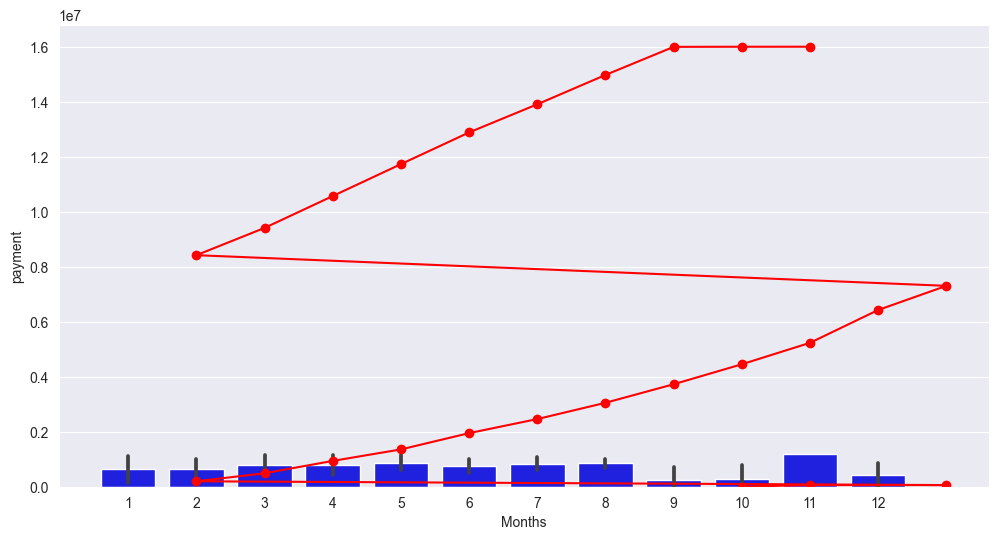

In [132]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Months', y='payment', data=df, color='blue', label='Monthly Payment')

# Overlay the line plot for cumulative sum
plt.plot(df['Months'], df['Cumulative_sum'], marker='o', color='red', label='Cumulative Sum')

Q3. Calculate the year-over-year growth rate of total sales.

In [133]:
query = '''with a as (SELECT year(o.order_purchase_timestamp) as years,SUM(payment_value) as Revenue
FROM orders as o 
INNER JOIN payments as P USING(order_id)
GROUP BY years 
ORDER BY years)
SELECT years,Revenue,lag(Revenue,1) over(ORDER BY years) previous_year_revenue, 
((Revenue-lag(Revenue,1) over(ORDER BY years))/lag(Revenue,1) over(ORDER BY years))*100 AS yoy_per
FROM a;'''

cursor.execute(query)
data = cursor.fetchall()

In [135]:
df = pd.DataFrame(data,columns=['Years','Revenue','Pre_year_reve','YoY_growth'])
df

,Years,Revenue,Pre_year_reve,YoY_growth
0,2016,5.936234e+04,NaN,NaN
1,2017,7.249747e+06,5.936234e+04,12112.703760
2,2018,8.699763e+06,7.249747e+06,20.000924


Q4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [137]:
query = '''WITH a AS (
    SELECT customer_id, MIN(o.order_purchase_timestamp) AS First_order
    FROM customer 
    INNER JOIN orders o USING(customer_id)
    GROUP BY customer_id
),

b AS (
    SELECT a.customer_id, COUNT(DISTINCT o.order_purchase_timestamp) AS next_order
    FROM a
    JOIN orders o ON a.customer_id = o.customer_id
    WHERE o.order_purchase_timestamp > a.First_order
    AND o.order_purchase_timestamp < DATE_ADD(a.First_order, INTERVAL 6 MONTH)
    GROUP BY a.customer_id
)

SELECT 100 * (COUNT(DISTINCT a.customer_id) / COUNT(DISTINCT b.customer_id)) AS percentage
FROM a 
LEFT JOIN b ON a.customer_id = b.customer_id;
'''


cursor.execute(query)
data = cursor.fetchall()
data

((None,),)

5. Identify the top 3 customers who spent the most money in each year.

In [138]:
query = '''SELECT years,customer_id,payment,d_rank
FROM

(SELECT year(o.order_purchase_timestamp) AS Years,o.customer_id,SUM(p.payment_value) AS payment,
DENSE_RANK() OVER(PARTITION BY year(o.order_purchase_timestamp) ORDER BY SUM(P.payment_value)) as d_rank
FROM orders o
INNER JOIN payments p USING(ORDER_ID) 
GROUP BY year(o.order_purchase_timestamp),o.customer_id) t
WHERE d_rank<=3;
'''

cursor.execute(query)
data = cursor.fetchall()

In [140]:
df= pd.DataFrame(data,columns=['Years','Customer_id','Payment','D_Rank'])
df

,Years,Customer_id,Payment,D_Rank
0,2016,4bb880cac21c7a9e1371ab1ebd601706,18.620001,1
1,2016,0975c3cf2e418ebfa5d1191a2dffd59d,19.620001,2
2,2016,59b219b2e1d1b20580c3551e07db6648,20.110001,3
3,2017,184e8e8e48937145eb96c721ef1f0747,10.070000,1
4,2017,d2c63ad286e3ca9dd69218008d61ff81,11.620000,2
5,2017,c466c7e0ab222e3ef6c8046e96128a8d,11.630000,3
6,2017,55cd7bfe95dcd698acf176278e14888e,11.630000,3
7,2018,a73c1f73f5772cf801434bf984b0b1a7,0.000000,1
8,2018,197a2a6a77da93f678ea0d379f21da0a,0.000000,1
9,2018,3532ba38a3fd242259a514ac2b6ae6b6,0.000000,1
